In [6]:
"""
1. Make a simple bigram model
2. Do a mlp model
2. Do a wavenet model
3. Do a GPT model
"""
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import torch
from torch import nn
from dataclasses import dataclass
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pandas as pd
@dataclass
class Config:
    batch_size: int

@torch.no_grad()
@torch.inference_mode()
def eval(device):
    losses = []
    for X, Y in iter(dl_val):
        X = X.to(device)
        Y = Y.to(device)
        y_logit, loss = model(X, Y)
        losses.append(loss.item())
    return torch.mean(torch.tensor(losses)).item()

batch_size=32
block_size=8

In [8]:
# !wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
# !wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

In [9]:
from gpt.bigram import BiGram, MLP
from gpt.data import TextDataset
from gpt.wavenet import make_wavenet
torch.optim.lr_scheduler.StepLR

ds_train = TextDataset('names.txt','train', block_size=block_size)
ds_val = TextDataset('names.txt','val', block_size=block_size)

dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ds_val, batch_size=batch_size, shuffle=True)
vocab_size = len(ds_train.vocab)

In [27]:
model = make_wavenet(vocab_size, n_embd=24,n_hidden=128)
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


[(128, 27), (27,)]

In [37]:
d = [dict(name='X', out_size=tuple(x.shape))]
x = next(iter(dl_train))[0]
for layer in model.layers:
    x = layer(x)
    nparams = sum(x.nelement() for x in layer.parameters())
    params = [tuple(p.shape) for p in layer.parameters()]
    d.append(dict(name=layer.__class__.__name__, out_size=tuple(x.shape), nparams=nparams, params=params))

pd.DataFrame(d)

,name,out_size,nparams,params
0,X,"(32, 27)",NaN,NaN
1,Embedding,"(32, 8, 24)",648.0,"[(27, 24)]"
2,FlattenConsecutive,"(32, 4, 48)",0.0,[]
3,Linear,"(32, 4, 128)",6144.0,"[(48, 128)]"
4,BatchNorm1d,"(32, 4, 128)",256.0,"[(128,), (128,)]"
5,Tanh,"(32, 4, 128)",0.0,[]
6,FlattenConsecutive,"(32, 2, 256)",0.0,[]
7,Linear,"(32, 2, 128)",32768.0,"[(256, 128)]"
8,BatchNorm1d,"(32, 2, 128)",256.0,"[(128,), (128,)]"
9,Tanh,"(32, 2, 128)",0.0,[]


In [100]:
ds_train[len(ds_train)]

(tensor([14,  0,  1, 14,  9, 12,  0,  1]),
 tensor([ 0,  1, 14,  9, 12,  0,  1, 14]))

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  # ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  # Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  ix = torch.randint(0, len(ds_train)-1, (batch_size,))
  # Xb, Yb = [ds_train[ix_] for ix_ in ix] # batch X,Y
  Xb, Yb = zip(*[ds_train[ix_] for ix_ in ix])
  Xb = torch.stack(Xb, 0)
  Yb = torch.stack(Yb, 0)
  Yb = Yb[:, -1]
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update: simple SGD
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


      0/ 200000: 2.3940
  10000/ 200000: 2.2599
  20000/ 200000: 1.9669


In [91]:
Xb

(tensor([19,  0, 19,  1, 13,  1, 18,  9]),
 tensor([18,  0, 19, 11, 25,  0, 20, 18]),
 tensor([ 1, 21,  0, 10, 21, 19, 20, 25]),
 tensor([19,  5,  0,  3,  8,  1, 14, 14]),
 tensor([18, 18,  9, 20, 20,  0, 18,  5]),
 tensor([ 1, 14,  9, 12,  0,  1, 14]),
 tensor([ 9, 14,  4,  9,  7, 15,  0,  9]),
 tensor([ 4,  5, 14, 14,  9, 19, 19,  5]),
 tensor([11,  5, 25, 15, 14,  9,  0, 11]),
 tensor([ 1, 25,  5, 19,  0, 10,  1,  8]),
 tensor([ 0, 20,  1, 20,  5, 13,  0, 20]),
 tensor([25,  1, 14,  1,  0, 19,  1, 14]),
 tensor([ 1,  0,  1, 14,  4, 18, 18,  1]),
 tensor([13, 25,  1,  8,  0, 14,  1, 14]),
 tensor([ 1, 12,  9, 19,  9,  1,  0,  1]),
 tensor([14,  1,  5,  0, 10,  5, 14,  9]),
 tensor([12, 25, 14, 14,  0, 10,  1, 19]),
 tensor([ 0, 12,  5, 15,  0,  9, 19,  1]),
 tensor([ 0, 11,  1,  9, 20, 12, 25, 14]),
 tensor([14,  0, 11,  1, 19,  8,  9,  1]),
 tensor([14,  0,  8,  5, 18, 19,  8,  0]),
 tensor([ 1,  0, 11,  1, 19, 19,  9,  1]),
 tensor([19,  8,  9,  0,  9, 19,  8,  9]),
 tensor([ 0,  3

In [89]:
Xb.shape, Yb.shape

(torch.Size([32, 8]), torch.Size([32, 1]))

In [36]:
device = torch.device("cuda")
# model = BiGram(vocab_size)
model = MLP(vocab_size)
model = WaveNetDemo(vocab_size, n_embd=24,n_hidden=128)
model = model.to(device)
if hasattr(model,'seq'):
    with torch.no_grad():
      model.seq[-1].weight *= 0.1 # last layer make less confident

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150000)
train_losses = []
val_losses = {}

TypeError: 'Sequential' object is not subscriptable

In [30]:
# n_steps = 100000
max_epochs = 100
eval_freq = 1000
step = 0
done = False
for epoch in range(1, max_epochs+1):
    for i, (X,Y) in enumerate(iter(dl_train), start=1):
        step += 1
        # break
        X = X.to(device)
        Y = Y.to(device)
        y_logit, loss = model(X, Y)
        # break
        
        optimizer.zero_grad(True)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
        if step == 0 or step % eval_freq == 0:
            val_loss = eval(device)
            val_losses[step] = val_loss
            lr = optimizer.param_groups[0]['lr']
            print(f'{epoch}:{i}|s={step} loss: {loss.item()} val_loss: {val_loss} lr: {lr}')
            
        train_losses.append(float(loss))
                
    print('epoch done')


1:1000|s=1000 loss: 2.480644702911377 val_loss: 2.5974738597869873 lr: 0.01
1:2000|s=2000 loss: 2.5069589614868164 val_loss: 2.591014862060547 lr: 0.01
1:3000|s=3000 loss: 2.5190649032592773 val_loss: 2.6074411869049072 lr: 0.01
1:4000|s=4000 loss: 2.433551549911499 val_loss: 2.6010513305664062 lr: 0.01
1:5000|s=5000 loss: 2.463160514831543 val_loss: 2.5837934017181396 lr: 0.01
1:6000|s=6000 loss: 2.487713098526001 val_loss: 2.5930967330932617 lr: 0.01
epoch done
2:583|s=7000 loss: 2.4428935050964355 val_loss: 2.5960607528686523 lr: 0.01
2:1583|s=8000 loss: 2.4836795330047607 val_loss: 2.585817575454712 lr: 0.01
2:2583|s=9000 loss: 2.3952531814575195 val_loss: 2.588942766189575 lr: 0.01
2:3583|s=10000 loss: 2.4342470169067383 val_loss: 2.5839812755584717 lr: 0.01
2:4583|s=11000 loss: 2.4159412384033203 val_loss: 2.59263277053833 lr: 0.01
2:5583|s=12000 loss: 2.5461983680725098 val_loss: 2.5782523155212402 lr: 0.01
epoch done
3:166|s=13000 loss: 2.377253532409668 val_loss: 2.58551311492

In [31]:
# list(model.parameters())[0].var(0)

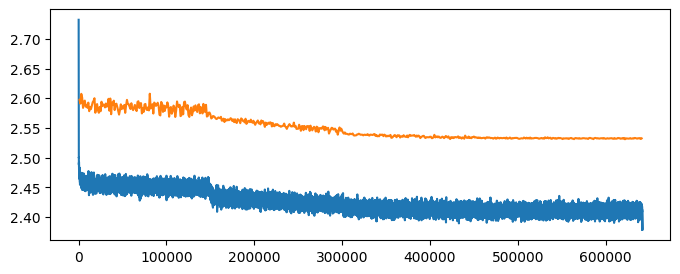

In [32]:
from scipy.signal import savgol_filter
train_losses_smoothed = savgol_filter(train_losses, 100, 1)
fig, ax = plt.subplots(1,1,figsize=(8,3))
i = list(range(0, len(train_losses), eval_freq))
ax.plot(train_losses_smoothed)
ax.plot(val_losses.keys(),val_losses.values())

In [12]:
ds_val[0]

(tensor([14, 21,  5, 12,  0,  1, 14, 19]),
 tensor([21,  5, 12,  0,  1, 14, 19, 21]))

In [13]:
x = ds_val[0][0].unsqueeze(0)
y_pred = model.predict(X, 1000)
print(''.join(ds_train.decode(y_pred[0])))

yal
aroamaqusicanynande
gevwayar
fil
a
han
pobruemna
geiyn
elynan
s
ela
ceriekanyarllel
brrolasvaniaha
myakahoratazwenonth
r
ariedenetahoreh
n
aiogramayn
x
aytaniayahangon
epah
gran
deay
lerusan
maerailalon
ayabrus
ylle
sly
aly
arsatssetoha
sanaifambade
maduoy
cema
zuk
bignde
son
b
rro
kovigian
wh
juryn
eam
co
aman
ckestth
beren
zianoamicaumiitlerlyn
gi
belajole
bana
aqueilya
t
briyn
n
etha
stzeren
alariseaylas
le
ierierlaavelen
peat
enshai
kian
beryn
ereyshttittrie
phe
ricke
lar
cer
ajon
distalelelumaramcabra
llonca
janynigi
ara
fareginala
toesarthan
ta
kyeaainn
ylimi
mow
d
cor
malismiaman
kularon
lcavi
anemalynckenazetilysite
conesh
elia
llli
a
lllor
ceyr
figisen
mayr
kicen
ze
sen
kide
dielisiealyaz
vieleaynerarinaai
tabinenas
benyarinaya
saral
zan
ara
n
linahan
aroria
ctophe
a
a
myeligrama
sa
s
zan
lele
s
zilannnamalme
lisa
ma
s
rin
mi
domdllelfet
julay
kisoieyahn
prika
chveranyma
hi
ce
pan
b
cqucoroniahnahyllideiyiscad
anann
kayaegwayliyna
toniyoin
syaronn
w
manemamacovi
calyie
lar

In [121]:
X.shape

torch.Size([9, 8])

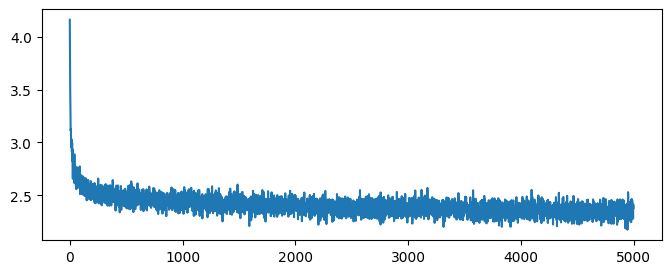

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(torch.as_tensor(losses).view(-1, 20).mean(1))

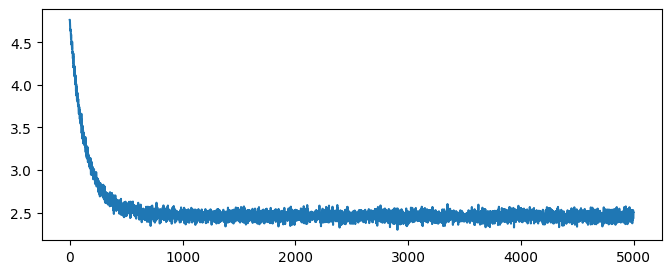

In [235]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
ax.plot(torch.as_tensor(losses).view(-1, 20).mean(1))

In [239]:
''.join(ds_train.decode(model.predict(X, 1000)[0]))

"rifave tentha n is il tinoue, l ie s tot SAnt fos oowi'ste n cilld harr tet; be s h grors ake, he kik\nF f foxthe iverrfeoran ce fisin suean;\nhe: w honous, gen har warry s, t horol mbleliglllly s mes PONoseaingn, matherds\nAUThaved RIO,\nAs!\nThour.\nHUCis;\nThie INGo;\nBE: foladopefit, pit se adve, h hatriernoay lecet asby wbe ff;\nA G tajou l\n\n\nRO:\nI l ags fandet VIShill.\nMathalemu\nOLAREWre ld MPred se mousoteall, mst, te d s I ts fl hat;\nCAnd tousenconowakesim,\nThur ve rorecthithase; gug mpplyo arean GBunok I MPRDWeag s haughe LI d thar,\n\nTUSetar want-t it t INThesetre wne tove ave hatt as y e y, d lpa brimugnd prd\nANThous mevol m ondeenermaverthimo tanin-m h mefry sot y und, our tar ck Hounghathe wirismyo wacevart.\nS:\nTourdertly t---dooandiromo 'sashashyor te pel mar, de't;\nGAPr d:\nR:\n\nMENoun tr-\n\nCEDWhin soucovene mumetolotours ge; be ve tootulyl oo'meantuaize sst en! IStoun, anis fund! he Wrd, binglt theel nt hiovave d ar, himas my, thashes.\nTwht! s.\nKIINCK

In [40]:
y_logit.shape

torch.Size([1, 8, 65])